In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
sys.path.append('/home/Ruth.Moorman/OM4p25_JRA55-do_simulations')
### import required python functions
from om4_tools import *
from ssh_contours import *
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import sys
sys.path.append('/home/Ruth.Moorman/')
import nclcmaps
import cv2
rcParams["contour.negative_linestyle"] = 'solid'
rc('xtick', labelsize=30) 
rc('ytick', labelsize=30) 
rc('axes', labelsize=30)

In [2]:
# start with mapping the bathymetry
# only interested in the Southern Ocean south of 29S generally
om4p25_static = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r_cycle1/'
lat_north = -29
static = xr.open_dataset(om4p25_static+'ocean_static/20170101.ocean_static.nc')
bathy = static.deptho.sel(yh = slice(-90,lat_north))
land_mask = static.wet.sel(yh = slice(-90,lat_north))

In [3]:
def so_basics(ax, land_mask=land_mask, lat_north = -29, grid = True):
    ax.contour(land_mask.sel(yh = slice(-90,lat_north)).xh, land_mask.sel(yh = slice(-90,lat_north)).yh,land_mask.sel(yh = slice(-90,lat_north)),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [4]:
# original, unaltered contour 
cmems_obs = xr.open_mfdataset('/work/Ruth.Moorman/CMEMS_SSH/dataset-duacs-rep-global-merged-allsat-phy-l4*.nc')
# these data are dailyabsolute dynamic topography (ssh above the geiod)
cmems_obs = cmems_obs.adt

## Annual

In [5]:
# full time mean (overlap with models)
# the model run only goes to 2017, so may as well remove the latest years
cmems_obs_mean = cmems_obs.sel(time = slice(None, '2017')).mean(dim = 'time').load()
# annual mean
cmems_obs_annual = cmems_obs.groupby('time.year').mean().load()


In [6]:
# initate empty for masks
empty = np.empty((27,245,1440))
empty[:,:,:] = np.nan
ssh_mask_cmems_annual = xr.DataArray(empty, coords = cmems_obs_annual.coords)
ssh_mask_cmems_annual.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous ssh contour'
ssh_mask_cmems_annual.attrs['time_avg_info'] = 'annual mean ssh used'
# initate empty for numbers (in case later you want to do the index thing, might as well compute once)
empty = np.empty((27,245,1440))
empty[:,:,:] = np.nan
ssh_numbers_cmems_annual = xr.DataArray(empty, coords = cmems_obs_annual.coords)
ssh_numbers_cmems_annual.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous ssh contour'
ssh_numbers_cmems_annual.attrs['time_avg_info'] = 'annual mean ssh used'
# intiate empty for ssh value at contour
empty = np.empty((27))
empty[:] = np.nan
ssh_contour_value = xr.DataArray(empty, coords = [cmems_obs_annual.year], dims = 'year')

In [7]:
range_min = np.round(cmems_obs_annual.isel(longitude = 0).min(dim = 'latitude').values, decimals = 3)

In [8]:
%%time
for y in range(27):
    print(y)
    test_range = np.arange(range_min[y]+0.1, -0.9, 0.001)
    contour_numbered, contour_mask, _, contour_depth = CMEMS_southernmost_continuous_ssh_contour(cmems_obs_annual.isel(year = y), test_range, lat_north = -29)
    ssh_mask_cmems_annual[y,:,:] = contour_mask.values
    ssh_numbers_cmems_annual[y,:,:] = contour_numbered.values
    ssh_contour_value[y] = contour_depth

0
Southernmost circumpolar continuous profile at ssh =  -1.0880000000000372
1
Southernmost circumpolar continuous profile at ssh =  -1.0780000000000396
2
Southernmost circumpolar continuous profile at ssh =  -1.092000000000035
3
Southernmost circumpolar continuous profile at ssh =  -1.0980000000000345
4
Southernmost circumpolar continuous profile at ssh =  -1.1130000000000329
5
Southernmost circumpolar continuous profile at ssh =  -1.0860000000000367
6
Southernmost circumpolar continuous profile at ssh =  -1.0920000000000356
7
Southernmost circumpolar continuous profile at ssh =  -1.0630000000000408
8
Southernmost circumpolar continuous profile at ssh =  -1.0610000000000392
9
Southernmost circumpolar continuous profile at ssh =  -1.0820000000000367
10
Southernmost circumpolar continuous profile at ssh =  -1.0440000000000387
11
Southernmost circumpolar continuous profile at ssh =  -1.0500000000000413
12
Southernmost circumpolar continuous profile at ssh =  -1.0500000000000378
13
Souther

In [11]:
ssh_mask_cmems_annual

<xarray.DataArray (year: 27, latitude: 245, longitude: 1440)>
array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... -29.125 -28.875
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2016 2017 2018 2019
Attributes:
    long_name:      Mask for the region south of the southernmost cicumpolar ...
    time_avg_info:  annual mean ssh used

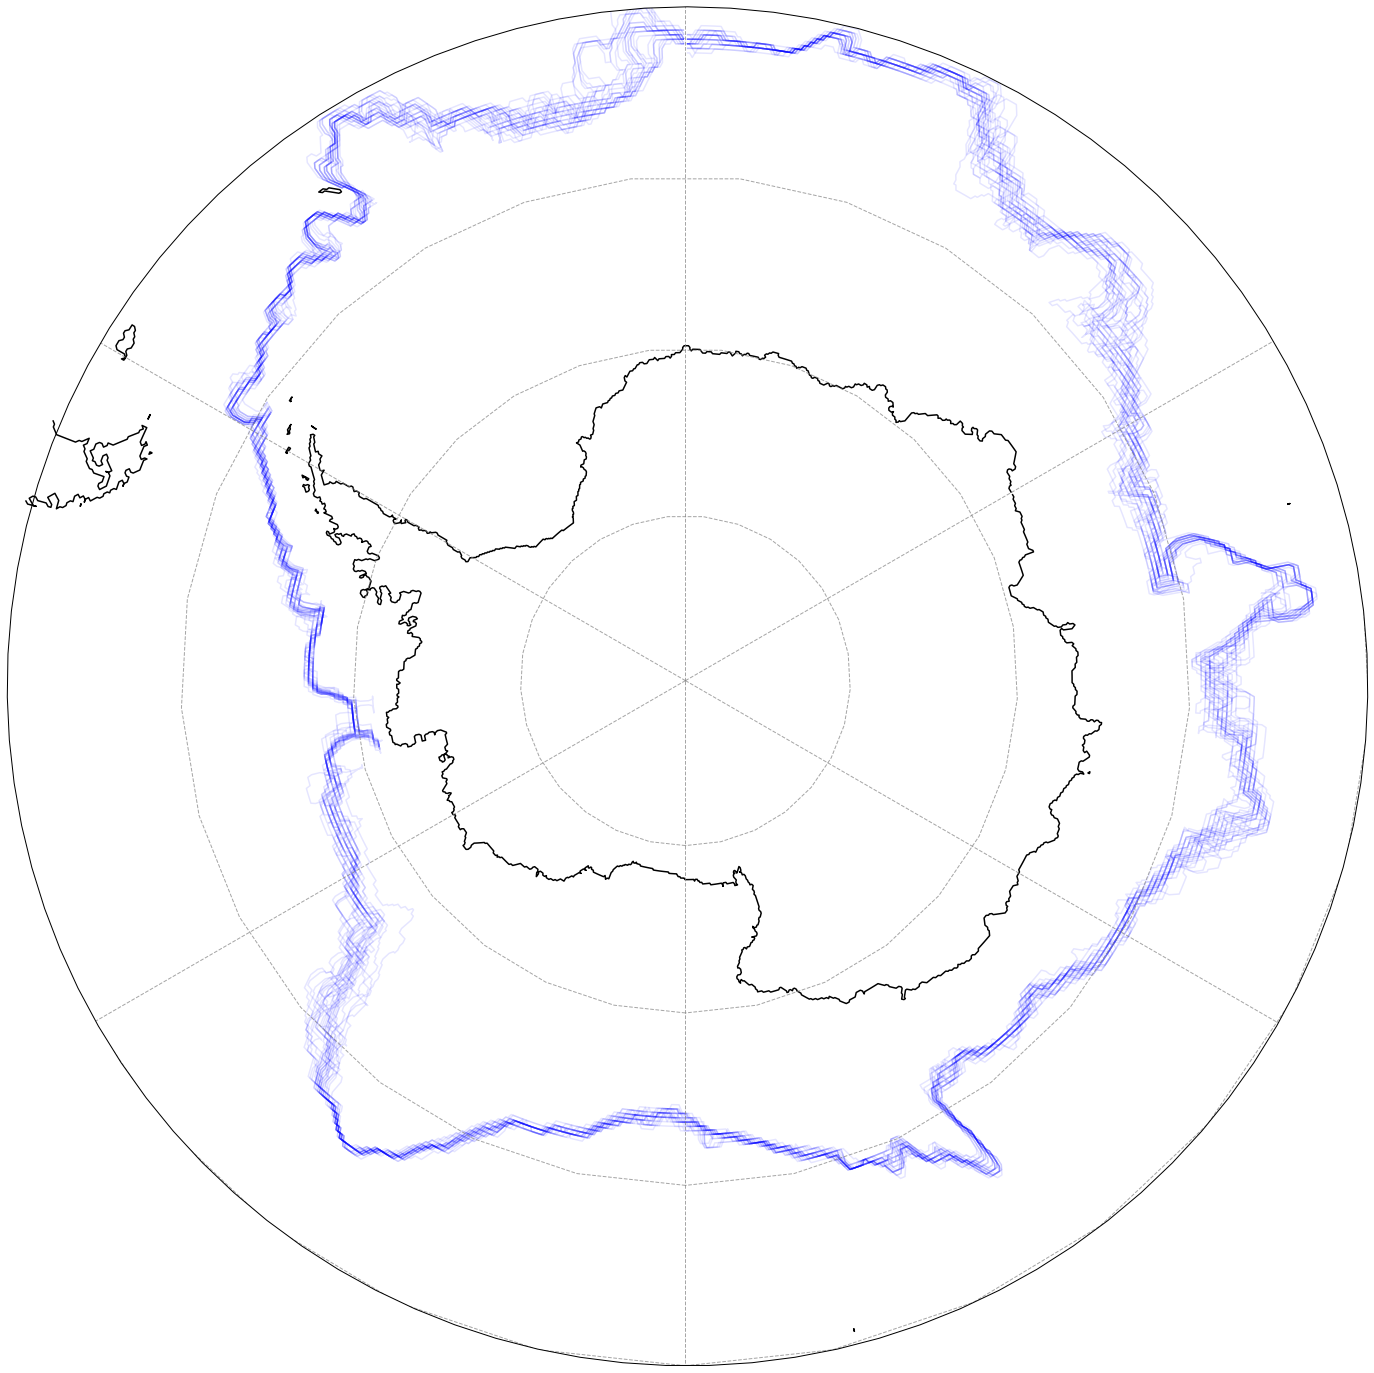

In [10]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
for i in range(27):
    ax.contour(ssh_mask_cmems_annual.isel(year = i).longitude, ssh_mask_cmems_annual.isel(year = i).latitude,ssh_mask_cmems_annual.isel(year = i).fillna(0), levels = [0,1], colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()

In [18]:
ssh_numbers_cmems_annual = xr.DataArray(ssh_numbers_cmems_annual, coords = {'year':ssh_numbers_cmems_annual.year, 'latitude':ssh_numbers_cmems_annual.latitude, 'longitude':ssh_numbers_cmems_annual.longitude, 'ssh_contour_value': ssh_contour_value}, attrs = ssh_numbers_cmems_annual.attrs)
ssh_mask_cmems_annual = xr.DataArray(ssh_mask_cmems_annual, coords = {'year':ssh_mask_cmems_annual.year, 'latitude':ssh_mask_cmems_annual.latitude, 'longitude':ssh_mask_cmems_annual.longitude, 'ssh_contour_value': ssh_contour_value}, attrs = ssh_mask_cmems_annual.attrs)
ds = xr.Dataset({'contour_mask_numbered':ssh_numbers_cmems_annual, 'contour_masked_south':ssh_mask_cmems_annual})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/CMEMS-satellite-obs/cmems_1993-2017_annual_SCC-ssh_contour.nc')

In [19]:
ssh_mask_cmems_annual

<xarray.DataArray (year: 27, latitude: 245, longitude: 1440)>
array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * year               (year) int64 1993 1994 1995 1996 ... 2016 2017 2018 2019
  * latitude           (latitude) float32 -89.875 -89.625 ... -29.125 -28.875
  * longitude          (longitude) float32 0.125 0.375 0.625 ... 359.625 359.875
    ssh_contour_value  (year) float64 -1.088 -1.078 -1.092 ... -1.061 -1.048
Attributes:
    long_name:      Mask for the region south of the southernmost cicumpolar ...
    time_avg_info:  annual mean ssh used

# Monthly

In [29]:
# might as well do the climatology, then maybe all months
# satellite era monthly climatology
cmems_obs_clim = cmems_obs.sel(time = slice(None, '2017')).groupby('time.month').mean().load()

In [31]:
# initate empty for masks
empty = np.empty((12,245,1440))
empty[:,:,:] = np.nan
ssh_mask_cmems_clim = xr.DataArray(empty, coords = cmems_obs_clim.coords)
ssh_mask_cmems_clim.attrs['long_name'] = 'Mask for the region south of the southernmost cicumpolar continuous ssh contour'
ssh_mask_cmems_clim.attrs['time_avg_info'] = '1993-2017 climatology ssh used'
# initate empty for numbers (in case later you want to do the index thing, might as well compute once)
empty = np.empty((12,245,1440))
empty[:,:,:] = np.nan
ssh_numbers_cmems_clim = xr.DataArray(empty, coords = cmems_obs_clim.coords)
ssh_numbers_cmems_clim.attrs['long_name'] = 'Numbered southernmost cicumpolar continuous ssh contour'
ssh_numbers_cmems_clim.attrs['time_avg_info'] = '1993-2017 climatology ssh used'
# intiate empty for ssh value at contour
empty = np.empty((12))
empty[:] = np.nan
ssh_contour_value = xr.DataArray(empty, coords = [cmems_obs_clim.month], dims = 'month')

In [32]:
range_min = np.round(cmems_obs_clim.isel(longitude = 0).min(dim = 'latitude').values, decimals = 3)

In [34]:
%%time
for y in range(12):
    print(y)
    test_range = np.arange(range_min[y]+0.1, -0.9, 0.001)
    contour_numbered, contour_mask, _, contour_depth = CMEMS_southernmost_continuous_ssh_contour(cmems_obs_clim.isel(month = y), test_range, lat_north = -29)
    ssh_mask_cmems_clim[y,:,:] = contour_mask.values
    ssh_numbers_cmems_clim[y,:,:] = contour_numbered.values
    ssh_contour_value[y] = contour_depth

0
Southernmost circumpolar continuous profile at ssh =  -1.0620000000000345
1
Southernmost circumpolar continuous profile at ssh =  -1.0640000000000354
2
Southernmost circumpolar continuous profile at ssh =  -1.0660000000000376
3
Southernmost circumpolar continuous profile at ssh =  -1.0650000000000386
4
Southernmost circumpolar continuous profile at ssh =  -1.0530000000000401
5
Southernmost circumpolar continuous profile at ssh =  -1.0650000000000388
6
Southernmost circumpolar continuous profile at ssh =  -1.058000000000039
7
Southernmost circumpolar continuous profile at ssh =  -1.0620000000000398
8
Southernmost circumpolar continuous profile at ssh =  -1.0370000000000341
9
Southernmost circumpolar continuous profile at ssh =  -1.0630000000000326
10
Southernmost circumpolar continuous profile at ssh =  -1.0730000000000341
11
Southernmost circumpolar continuous profile at ssh =  -1.077000000000033
CPU times: user 24min 9s, sys: 299 ms, total: 24min 9s
Wall time: 24min 8s


In [35]:
ssh_mask_cmems_clim

<xarray.DataArray (month: 12, latitude: 245, longitude: 1440)>
array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... -29.125 -28.875
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      Mask for the region south of the southernmost cicumpolar ...
    time_avg_info:  1993-2017 climatology ssh used

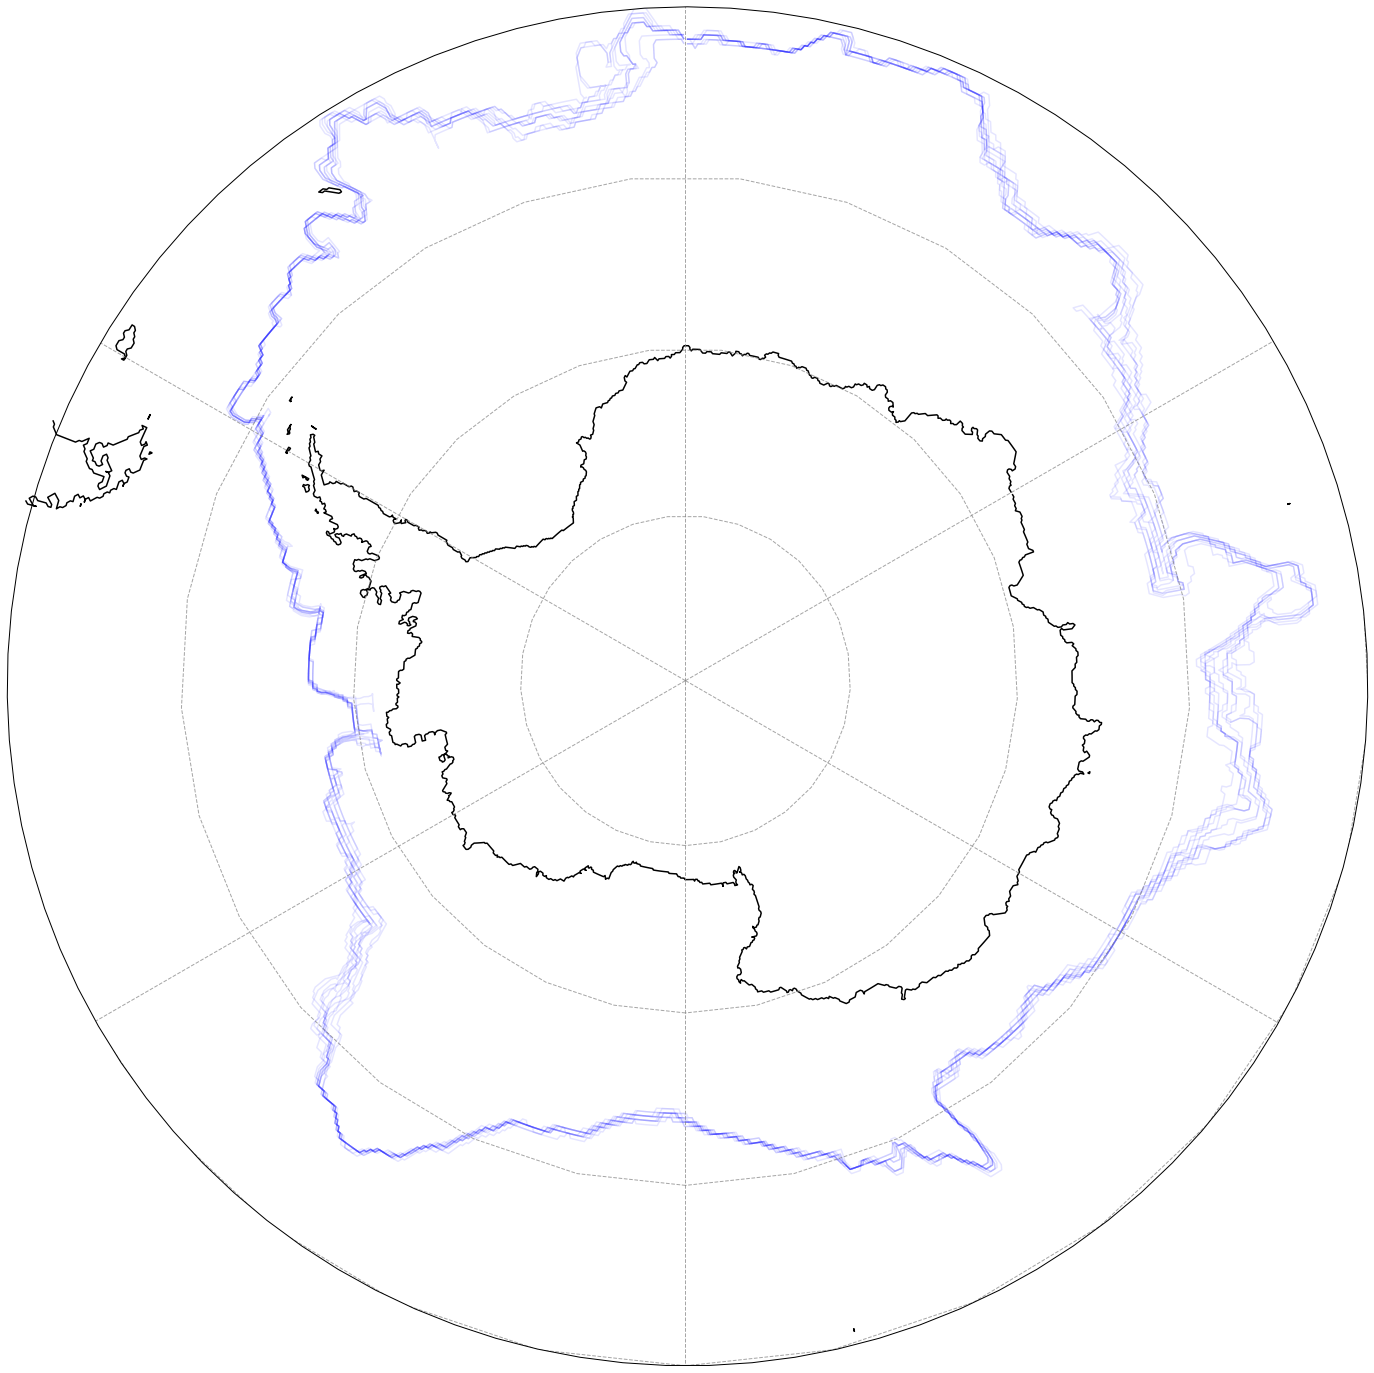

In [36]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
for i in range(12):
    ax.contour(ssh_mask_cmems_clim.isel(month = i).longitude, ssh_mask_cmems_clim.isel(month = i).latitude,ssh_mask_cmems_clim.isel(month = i).fillna(0), levels = [0,1], colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()

In [37]:
ssh_numbers_cmems_clim = xr.DataArray(ssh_numbers_cmems_clim, coords = {'month':ssh_numbers_cmems_clim.month, 'latitude':ssh_numbers_cmems_clim.latitude, 'longitude':ssh_numbers_cmems_clim.longitude, 'ssh_contour_value': ssh_contour_value}, attrs = ssh_numbers_cmems_clim.attrs)
ssh_mask_cmems_clim = xr.DataArray(ssh_mask_cmems_clim, coords = {'month':ssh_mask_cmems_clim.month, 'latitude':ssh_mask_cmems_clim.latitude, 'longitude':ssh_mask_cmems_clim.longitude, 'ssh_contour_value': ssh_contour_value}, attrs = ssh_mask_cmems_clim.attrs)
ds = xr.Dataset({'contour_mask_numbered':ssh_numbers_cmems_clim, 'contour_masked_south':ssh_mask_cmems_clim})
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/CMEMS-satellite-obs/cmems_1993-2017_climatology_SCC-ssh_contour.nc')

In [24]:
cmems_obs.groupby('time.month')

DataArrayGroupBy, grouped over 'month' 
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [26]:
cmems_obs.resample(time="MS")

DataArrayResample, grouped over '__resample_dim__' 
317 groups with labels 1993-01-01, ..., 2019-05-01.

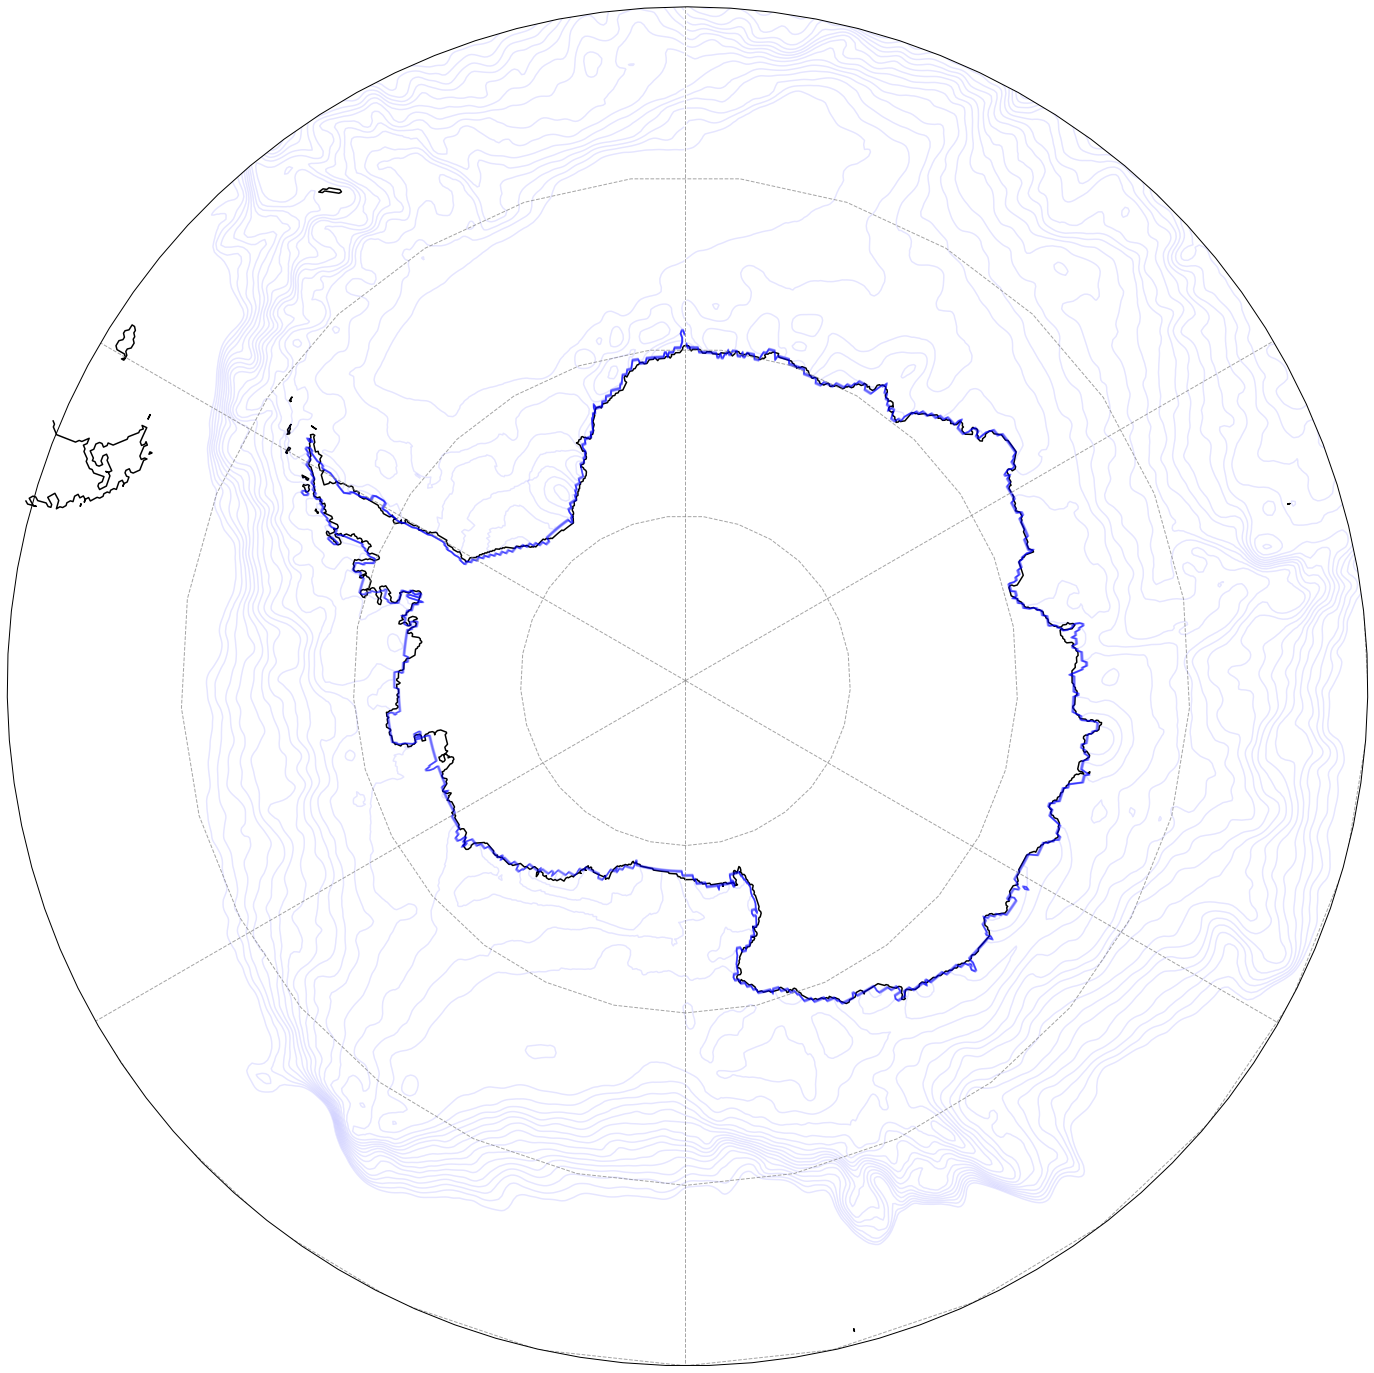

In [42]:
fig = plt.figure(figsize=[25, 25])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask,lat_north = -50)
lvls = np.arange(-1.4,-0.5, 0.05)
ax.contour(cmems_obs_mean.longitude, cmems_obs_mean.latitude,cmems_obs_mean.fillna(0), levels = lvls, colors = 'b', alpha = 0.1, transform = ccrs.PlateCarree())
plt.show()